In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary
from comet_ml import Experiment

# Local imports
sys.path.append("/Users/leo/Programming/Thesis/utils")
sys.path.append("/Users/leo/Programming/Thesis/models")

from helper_functions import (delete_ds_store,plot_metrics,test,train,mean_std_finder,load_model)
from MBNV3 import MBNV3_Creator
from config import comet_token, project_name, workspace
from torchvision.models import (mobilenet_v3_small, MobileNet_V3_Small_Weights as weights_small)

# Setting the seed for reproducibility
torch.manual_seed(42)

In [2]:
prms = {
    "backbone": mobilenet_v3_small,
    "weights": None,
    "module": None,
    "module_alias": "SE",
    "data_path": "/Users/leo/Programming/Thesis/data/vgg_25/",
    "batch_size": 32,
    "img_size": 224,
    "num_classes": 25,
    "epochs": 25,
    "learning_rate": 0.001,
    "device": "mps",
    "model": None,
    "experiment": Experiment(api_key=comet_token, project_name=project_name, workspace=workspace, log_code=True),
    "load_model": False,
}
prms["model_save_path"] = f"./saved_weights/{prms['module_alias']}_{prms['data_path'].split('/')[-2]}.pth"

model = prms["model"] = MBNV3_Creator(prms["num_classes"], prms["device"])
delete_ds_store(prms["data_path"])

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/leothesouthafrican/test/ea76f9344c0746cd9130a7a42dd9a936



In [3]:
#mean, std = mean_std_finder(prms["data_path"])
mean, std = torch.tensor([0.5235, 0.4358, 0.3905]), torch.tensor([0.2993, 0.2770, 0.2729])

train_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
#Accessing the data
train_data = torchvision.datasets.ImageFolder(prms["data_path"] + "train/", transform=train_transform)
val_data = torchvision.datasets.ImageFolder(prms["data_path"] + "val/", transform=test_transform)
test_data = torchvision.datasets.ImageFolder(prms["data_path"] + "test/", transform=test_transform)

#Creating the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=prms["batch_size"], shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


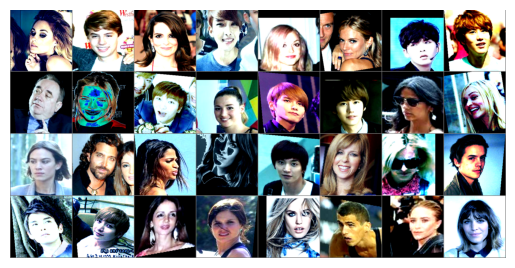

In [5]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
#build the model
model = load_model(model.build_model(), prms["model_save_path"]) if prms["load_model"] else model.build_model()

# Loss and optimizer
criterion = nn.CrossEntropyLoss().to(prms["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=prms["learning_rate"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

prms["experiment"].log_parameters({"loss": criterion, "optimizer": optimizer}) if prms["experiment"] else None

SE block in layers: [1, 4, 5, 6, 7, 8, 9, 10, 11].
Model weights initialized with Xavier initialization.


In [7]:
model_summary = summary(model, input_size=(1, 3, prms["img_size"], prms["img_size"]),
        col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"],
        col_width = 20,
        row_settings = ["var_names"],
        depth=8)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
prms["experiment"].log_metric("total_params", total_params) if prms["experiment"] else None

model_summary

/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
MobileNetV3 (MobileNetV3)                                    [1, 3, 224, 224]     [1, 25]              --                   --                   --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 576, 7, 7]       --                   --                   --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 16, 112, 112]    --                   --                   --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 16, 112, 112]    432                  [3, 3]               5,419,008            True
│    │    └─BatchNorm2d (1)                                  [1, 16, 112, 112]    [1, 16, 112, 112]    32                   --              

In [8]:
#train the model
train_losses, train_acc, val_losses, val_acc = train(model, train_loader, val_loader, criterion, optimizer, scheduler, hyper_params = prms, verbose = 2, test_transform = train_transform, experiment=prms["experiment"])

#plot the training and validation metrics
plot_metrics(train_losses, train_acc, val_losses, val_acc)

100%|██████████| 439/439 [01:14<00:00,  5.87it/s]


last conv layer: Conv2d(96, 576, kernel_size=(1, 1), stride=(1, 1), bias=False)


100%|██████████| 55/55 [00:04<00:00, 12.20it/s]


Epoch: 01 | Epoch Time: 1.0m 21s
	Train Loss: 2.858 | Train Acc: 12.95%
	 Val. Loss: 3.126 |  Val. Acc: 4.82%
Best Accuracy Achieved: 4.82% on epoch 01


100%|██████████| 439/439 [01:27<00:00,  5.00it/s]


last conv layer: Conv2d(96, 576, kernel_size=(1, 1), stride=(1, 1), bias=False)


100%|██████████| 55/55 [00:05<00:00, 10.31it/s]


Epoch: 02 | Epoch Time: 1.0m 33s
	Train Loss: 2.571 | Train Acc: 20.46%
	 Val. Loss: 2.375 |  Val. Acc: 26.28%
Best Accuracy Achieved: 26.28% on epoch 02


100%|██████████| 439/439 [01:42<00:00,  4.28it/s]


last conv layer: Conv2d(96, 576, kernel_size=(1, 1), stride=(1, 1), bias=False)


100%|██████████| 55/55 [00:06<00:00,  9.02it/s]


Epoch: 03 | Epoch Time: 1.0m 50s
	Train Loss: 2.284 | Train Acc: 28.22%
	 Val. Loss: 2.063 |  Val. Acc: 33.16%
Best Accuracy Achieved: 33.16% on epoch 03


  0%|          | 0/439 [00:00<?, ?it/s]

In [ ]:
#test the model
test(model, test_loader, criterion, hyper_params = prms, experiment = prms["experiment"])

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leothesouthafrican/test/0c238b68adcc4a93b7c3e38c566fb12f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     inference_time  : 0.00546695082976309
COMET INFO:     test_accuracy   : 0.662901759147644
COMET INFO:     test_loss       : 1.282971724898759
COMET INFO:     total_params    : 1620356
COMET INFO:     train_acc [25]  : (0.1297963708639145, 0.7446799874305725)
COMET INFO:     train_loss [25] : (0.889845486957291, 3.6980211929664843)
COMET INFO:     val_acc [25]    : (0.25339967012405396, 0.6737976670265198)
COMET INFO:     val_loss [25]   : (1.2471367107843285, 2.9762818200473564)
COMET INFO:   Parameters:
COMET INFO:

Test loss: 1.283.. 
Test accuracy: 0.663
Test Time: 1.0m 5s 827ms


COMET INFO: Using '/Users/leo/Programming/Thesis/notebooks/.cometml-runs' path as offline directory. Pass 'offline_directory' parameter into constructor or set the 'COMET_OFFLINE_DIRECTORY' environment variable to manually choose where to store offline experiment archives.
COMET WARNING: Could not send live data to Comet during experiment runtime. An offline experiment will be available for upload:
    comet upload --force-reupload /Users/leo/Programming/Thesis/notebooks/.cometml-runs/0c238b68adcc4a93b7c3e38c566fb12f-GCgJfO.zip


(1.282971724898759, tensor(0.6629, device='mps:0'))